In [17]:
# !pip uninstall normflows
# !pip install nflows


In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, kstest
import normflows as nf
import json
import torch
import torch.nn as nn
# from nflows.flows.base import Flow
# from nflows.transforms.autoregressive import MaskedAutoregressiveTransform
# from nflows.transforms import CompositeTransform
# from nflows.distributions import StandardNormal
# from nflows.nn.nets import ResidualNet
# from nflows.transforms.splines import RationalQuadraticSpline, rational_quadratic_spline
# from nflows.nn.nets.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform

In [19]:
filename="Zmumu.json"
with open(filename, 'r') as file:
    data = json.load(file)

In [20]:
data2=np.array(data)

In [21]:
mean = data2.mean(axis=0)
std = data2.std(axis=0)
data_std = (data2 - mean) / std

X = torch.tensor(data_std, dtype=torch.float32)

In [22]:
from torch.utils.data import DataLoader, TensorDataset

# Assuming you have your data in a NumPy array X of shape (N, input_dim)
# or a PyTorch tensor

# Example: create random data (replace with your real data)
import numpy as np
X = np.random.rand(10000, 5).astype(np.float32)

# Convert to PyTorch tensor
X_tensor = torch.tensor(X)

# Create dataset and dataloader
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [23]:
dir(nf.flows)

['ActNorm',
 'AffineConstFlow',
 'AffineCoupling',
 'AffineCouplingBlock',
 'AutoregressiveRationalQuadraticSpline',
 'BatchNorm',
 'CCAffineConst',
 'CircularAutoregressiveRationalQuadraticSpline',
 'CircularCoupledRationalQuadraticSpline',
 'Composite',
 'CoupledRationalQuadraticSpline',
 'Flow',
 'GlowBlock',
 'HamiltonianMonteCarlo',
 'Invertible1x1Conv',
 'InvertibleAffine',
 'LULinearPermute',
 'MaskedAffineAutoregressive',
 'MaskedAffineFlow',
 'Merge',
 'MetropolisHastings',
 'PeriodicShift',
 'PeriodicWrap',
 'Permute',
 'Planar',
 'Radial',
 'Residual',
 'Reverse',
 'Split',
 'Squeeze',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'affine',
 'base',
 'mixing',
 'neural_spline',
 'normalization',
 'periodic',
 'planar',
 'radial',
 'reshape',
 'residual',
 'stochastic']

In [24]:
dim = X.shape[1]  # Assuming X is a 2D tensor with shape (num_samples, num_features)

import torch
import torch.nn as nn
import normflows as nf

# Define input dimensionality
input_dim = dim  # Replace with actual input dimension
num_layers = 8
hidden_units = 32
num_bins = 12

# Base distribution (Standard Gaussian)
q0 = nf.distributions.base.DiagGaussian(input_dim)

# Create list of flows (using Neural Spline Flow - autoregressive)
flows = []

for _ in range(num_layers):
    flows.append(
        nf.flows.AutoregressiveRationalQuadraticSpline(
            num_input_channels=input_dim,
            num_hidden_channels = hidden_units,
            num_blocks=2,
            num_bins=num_bins,
            tail_bound=1.0,
            activation=nn.ReLU,
            dropout_probability=0.0
            # tails='linear',
        )
    )




In [25]:
model = nf.NormalizingFlow(q0, flows)

In [26]:
# enable_cuda = True
# device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
device = 'cpu'
model = model.to(device)

In [27]:
# #Write the training code here.
# # Define optimizer and loss function
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# loss_fn = nf.losses.MeanSquaredError()
# # loss_fn = -model.log_prob(x).mean()

# # Training loop
# num_epochs = 1000
# batch_size = 128
# num_batches = len(X) // batch_size  
# for epoch in range(num_epochs):
#     model.train()
#     for i in range(num_batches):
#         batch = X[i * batch_size:(i + 1) * batch_size].to(device)
#         optimizer.zero_grad()
#         loss = loss_fn(model, batch)
#         loss.backward()
#         optimizer.step()
    
#     if (epoch + 1) % 100 == 0:
#         print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
# # Save the trained model
# torch.save(model.state_dict(), 'trained_model.pth') 

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    for x_batch in dataloader:  # Assuming you have a DataLoader
        # x_batch = x_batch.to(device)  # Optional: move to GPU
        # x_batch = x_batch.to(device)
        x_batch = x_batch[0].to(device)



        optimizer.zero_grad()
        
        # Log probability under the model
        log_prob = model.log_prob(x_batch)

        # Negative log-likelihood loss
        loss = -log_prob.mean()

        loss.backward()
        optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 2.1685


In [28]:
with torch.no_grad():
    beta = model.inverse(X_tensor).numpy()
    norms_sq = np.sum(beta**2, axis=1)

In [29]:
K = 11  # total bins
dof = 5
bin_edges = chi2.ppf(np.linspace(0, 1, K + 1), df=dof)


hist, _ = np.histogram(norms_sq, bins=bin_edges)
hist = hist[:10]
bin_edges = bin_edges[:11]  # only first 10 edges (10 bins)

bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_widths = np.diff(bin_edges)

# Normalized density
N = len(norms_sq)
hist_density = hist / (bin_widths * N)
errors = np.sqrt(hist) / (bin_widths * N)

# Expected from χ²
expected_density = chi2.pdf(bin_centers, dof)
expected_counts = (chi2.cdf(bin_edges[1:], dof) - chi2.cdf(bin_edges[:-1], dof)) * N

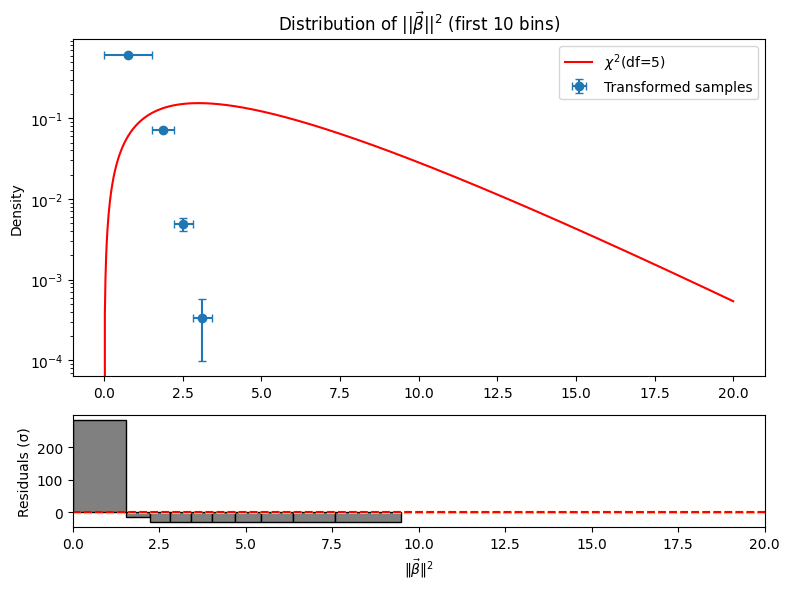

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1]})


xerr = bin_widths / 2
ax1.errorbar(
    bin_centers,
    hist_density,
    yerr=errors,
    xerr=xerr,
    fmt='o',
    label='Transformed samples',
    capsize=3
)
x = np.linspace(0, 20, 1000)
ax1.plot(x, chi2.pdf(x, dof), 'r-', label=f"$\chi^2$(df={dof})")
ax1.set_yscale('log')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of $||\\vec{\\beta}||^2$ (first 10 bins)')
ax1.legend()


residuals = hist - expected_counts
significance = residuals / np.sqrt(expected_counts)

ax2.bar(bin_centers, significance, width=bin_widths, color='gray', edgecolor='black')
for y in [-2, -1, 1, 2]:
    ax2.axhline(y, linestyle='--', color='red' if abs(y) == 2 else 'gold')
ax2.set_ylabel('Residuals (σ)')
ax2.set_xlabel(r"$\|\vec{\beta}\|^2$")
ax2.set_xlim(0, 20)

plt.tight_layout()
plt.show()